In [20]:
import sys
sys.path.append("..")


import numpy as np
import random
import csv

from idtrees.utils import read_tifs #, load_data # Import data utils
%matplotlib inline 
import matplotlib.pyplot as plt
from configs import *

## Read and Display One Hyperspectral Image

HSI image shape:  (369, 20, 20)


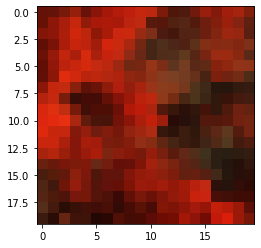

In [5]:
hsi_im_paths = read_tifs.get_im_paths('HSI')
im_id = 29
im = read_tifs.read_tif_to_ndarray(hsi_im_paths[im_id])

print('HSI image shape: ', im.shape)

# Grab a random three band combination
bands = (91,200,360)

# Plot an HSI Image 
im_plt = np.rollaxis(im[bands,:,:],0,start=3)
plt.imshow(im_plt)

## Show first n hyperspectral images 

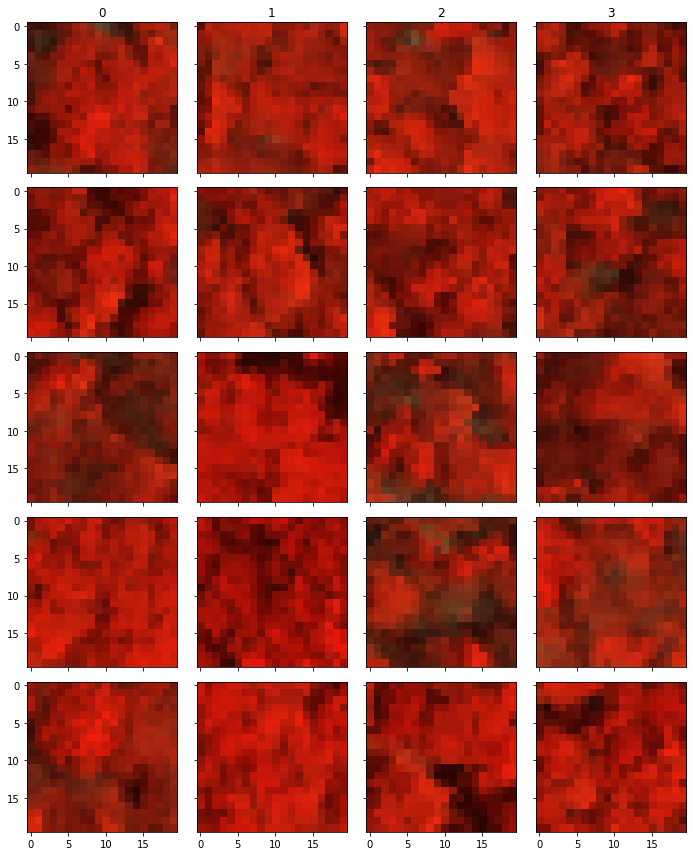

In [6]:
n = 20
ims = read_tifs.read_all_tif_to_ndarray(hsi_im_paths)[:n]
read_tifs.plot_all_ims(ims[:,bands,:,:], title='hsi')

In [7]:
# Read in all HSI images
ims_hsi = read_tifs.read_all_tif_to_ndarray(hsi_im_paths)
print('Total Number of HSI images: ', ims_hsi.shape[0])

Number of HSI images:  85


## Plot mean over all hyperspectral pixels in all images

(85, 369, 20, 20)


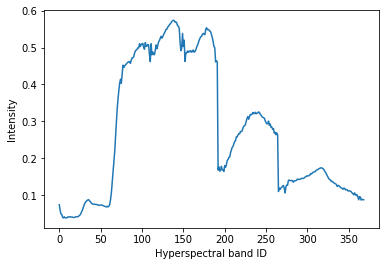

In [8]:
read_tifs.plot_spectral_curve(ims_hsi)

### Extracting ITCs as differently sized HSI images with a Tree Species Label

In [25]:
import torch
from idtrees.utils.dataset import TreeImagesDataset

# Load hsi dataset of bounding boxes with torch dataloader
csv_file ='data/data_train_mitree.csv'
root_dir = repo_path
image_dataset = TreeImagesDataset(csv_file, root_dir, object_rec=False, datatype='hsi', instance_type = 'boxes')
image_dataset = torch.utils.data.Subset(image_dataset, [0]) # TODO: find out what the [0] does

# Get number of bounding boxes in dataset
n_boxes = image_dataset.dataset.__len__()
print('Number of trees, labeled with species and bounding box: ', n_boxes)

Number of trees, labeled with species and bounding box:  1165


In [42]:
im_all = []
class_ids = []
for idx in range(n_boxes): 
    # Get image and target of current bounding box 
    im, target = image_dataset.dataset.__getitem__(idx)
    im_all.append(im)
    class_ids.append(target['labels'])
    
classes = np.unique(class_ids)

print("")
print("Number of HSI bounding boxes images: ", len(im_all))
print("Number of Class ID's: ", len(class_ids))
print("Number of Unique Tree Classes in Data: ", len(classes))


[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box

Number of HSI bounding boxes images:  1165
Number of Class ID's:  1165
Number of Unique Tree Classes in Data:  33


In [65]:
import pandas as pd
df = pd.read_csv(repo_path + 'data/train/Field/taxonID_ScientificName.csv')

class_id_val = []
n_im_val = []
sci_names = []

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')
for c in classes:
    ids_in_c = np.where(class_ids == c)[0]
    n_im = len([class_ids[x] for x in ids_in_c])
    sci_name = df[df.taxonCode==c].scientificName.iloc[0]
    class_id_val.append(c)
    n_im_val.append(n_im)
    sci_names.append(sci_name)
    
    print(str(int(c)) +":\t"+ str(n_im) + "\t"+  sci_name)

cls_id 	n_px 	scientific name
1:	8	Acer pensylvanicum L.
2:	139	Acer rubrum L.
3:	1	Acer saccharum Marshall
4:	46	Amelanchier laevis Wiegand
5:	6	Betula sp.
6:	3	Carya glabra (Mill.) Sweet
7:	1	Carya tomentosa (Lam.) Nutt.
8:	6	Fagus grandifolia Ehrh.
9:	1	Gordonia lasianthus (L.) Ellis
10:	17	Liriodendron tulipifera L.
11:	1	Lyonia lucida (Lam.) K. Koch
12:	15	Magnolia sp.
13:	2	Nyssa biflora Walter
14:	45	Nyssa sylvatica Marshall
15:	11	Oxydendrum sp.
16:	2	Persea palustris (Raf.) Sarg.
17:	6	Pinus elliottii Engelm.
18:	367	Pinus palustris Mill.
19:	9	Pinus sp.
20:	4	Pinus taeda L.
21:	7	Prunus serotina Ehrh.
22:	103	Quercus alba L.
23:	53	Quercus coccinea
24:	18	Quercus geminata Small
25:	5	Quercus hemisphaerica W. Bartram ex Willd.
26:	97	Quercus laevis Walter
27:	1	Quercus laurifolia Michx.
28:	12	Quercus montana Willd.
29:	3	Quercus nigra L.
30:	169	Quercus rubra L.
31:	1	Quercus sp.
32:	2	Robinia pseudoacacia L.
33:	4	Tsuga canadensis (L.) Carriere


### We only use the following class_ids
Can't use just the top 4 classes and group everything else into other because you then get a huge class imbalance. 

Use: (2, 4, 14, 18, 22, 23, 26, 30)
Other: All the rest 

In [111]:
keep = np.array([2., 4., 14., 18., 22., 23., 26., 30.])
im_keep = []
im_not_keep = []
new_class_ids = []


for c in keep:
    ids_in_c = np.where(class_ids == c)[0]
    n_im = [class_ids[x] for x in ids_in_c]
    for n in n_im:
        im_keep.append(n)
        new_class_ids.append(c)

for c in classes:
    if c not in keep:
        ids_nin_c = np.where(class_ids == c)[0] 
        n_im = [class_ids[x] for x in ids_nin_c]
        for n in n_im:
            im_not_keep.append(n)
            new_class_ids.append(34.)

print(len(im_not_keep), len(im_keep))

#combine into new total list, with a 34th class id known as 'Other'
im_all_new = im_keep 
im_all_new.extend(im_not_keep)

new_classes = np.unique(new_class_ids)
print(new_classes)


146 1019
[ 2.  4. 14. 18. 22. 23. 26. 30. 34.]


In [113]:
df.loc[34, :] = [34., 'OTHER', 'ALL Others']

class_id_val = []
n_im_val = []
sci_names = []

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')

for c in new_classes:
    ids_in_c = np.where(new_class_ids == c)[0]
    n_im = len([new_class_ids[x] for x in ids_in_c])
    sci_name = df[df.taxonCode==c].scientificName.iloc[0]
    class_id_val.append(c)
    n_im_val.append(n_im)
    sci_names.append(sci_name)
    
    print(str(int(c)) +":\t"+ str(n_im) + "\t"+  sci_name)
    

cls_id 	n_px 	scientific name
2:	139	Acer rubrum L.
4:	46	Amelanchier laevis Wiegand
14:	45	Nyssa sylvatica Marshall
18:	367	Pinus palustris Mill.
22:	103	Quercus alba L.
23:	53	Quercus coccinea
26:	97	Quercus laevis Walter
30:	169	Quercus rubra L.
34:	146	ALL Others


## Read in hyperspectral pixels of every tree bounding box with torch dataloader

In [40]:
data = read_tifs.get_hsi_pixels()


Number of trees, labeled with species and bounding box:  1165
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box


In [41]:
print('Data shape: ', data.shape)
print('Number of pixels within bounding boxes: ', data.shape[1])
class_ids = np.unique(data[0,:]) # Class_ids should start with 1
print('Number of classes: ', class_ids.shape[0])

Data shape:  (370, 35488)
Number of pixels within bounding boxes:  35488
Number of classes:  33


### Print class distribution, i.e., number of trees per class
#### Insights
- There is some classes with very little data (e.g., class 7, 11, 27)

In [8]:
import pandas as pd
df = pd.read_csv(repo_path + 'data/train/Field/taxonID_ScientificName.csv')

class_id_val = []
n_px_val = []
sci_names = []

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')
for c in class_ids:
    ids_in_c = np.argwhere([data[0,:] == c])[:,1]
    n_px = data[0,ids_in_c].shape[0]
    sci_name = df[df.taxonCode==c].scientificName.iloc[0]
    class_id_val.append(c)
    n_px_val.append(n_px)
    sci_names.append(sci_name)
    
    print(str(int(c)) +":\t"+ str(n_px) + "\t"+  sci_name)

cls_id 	n_px 	scientific name
1:	202	Acer pensylvanicum L.
2:	4647	Acer rubrum L.
3:	42	Acer saccharum Marshall
4:	1439	Amelanchier laevis Wiegand
5:	182	Betula sp.
6:	222	Carya glabra (Mill.) Sweet
7:	12	Carya tomentosa (Lam.) Nutt.
8:	76	Fagus grandifolia Ehrh.
9:	30	Gordonia lasianthus (L.) Ellis
10:	755	Liriodendron tulipifera L.
11:	8	Lyonia lucida (Lam.) K. Koch
12:	464	Magnolia sp.
13:	60	Nyssa biflora Walter
14:	1286	Nyssa sylvatica Marshall
15:	270	Oxydendrum sp.
16:	18	Persea palustris (Raf.) Sarg.
17:	186	Pinus elliottii Engelm.
18:	8700	Pinus palustris Mill.
19:	454	Pinus sp.
20:	238	Pinus taeda L.
21:	144	Prunus serotina Ehrh.
22:	4392	Quercus alba L.
23:	2066	Quercus coccinea
24:	402	Quercus geminata Small
25:	142	Quercus hemisphaerica W. Bartram ex Willd.
26:	2073	Quercus laevis Walter
27:	9	Quercus laurifolia Michx.
28:	487	Quercus montana Willd.
29:	76	Quercus nigra L.
30:	6207	Quercus rubra L.
31:	15	Quercus sp.
32:	66	Robinia pseudoacacia L.
33:	118	Tsuga canadensis 

In [9]:
freq = pd.DataFrame({'class_ids': class_id_val, 'num_pix': n_px_val, 'sci_names': sci_names})
print(freq)

    class_ids  num_pix                                   sci_names
0         1.0      202                       Acer pensylvanicum L.
1         2.0     4647                              Acer rubrum L.
2         3.0       42                     Acer saccharum Marshall
3         4.0     1439                  Amelanchier laevis Wiegand
4         5.0      182                                  Betula sp.
5         6.0      222                  Carya glabra (Mill.) Sweet
6         7.0       12                Carya tomentosa (Lam.) Nutt.
7         8.0       76                     Fagus grandifolia Ehrh.
8         9.0       30              Gordonia lasianthus (L.) Ellis
9        10.0      755                  Liriodendron tulipifera L.
10       11.0        8                Lyonia lucida (Lam.) K. Koch
11       12.0      464                                Magnolia sp.
12       13.0       60                        Nyssa biflora Walter
13       14.0     1286                    Nyssa sylvatica Mars

## Plot average hyperspectral curve per tree species
#### Insights: 
- The standard deviation over all pixels of the same species is very high (Note: the plot scales the std deviation down by 10) 
- The near-infrared spectrum (bands 60-200) has a lot stronger reflectance than the RGB spectrum (bands 0-60)
- TODO: Check if there's outliers that blow up std dev
- TODO: Check which bands are impacted by atmospheric absorbance (e.g., H2O) and if these bands have already been removed

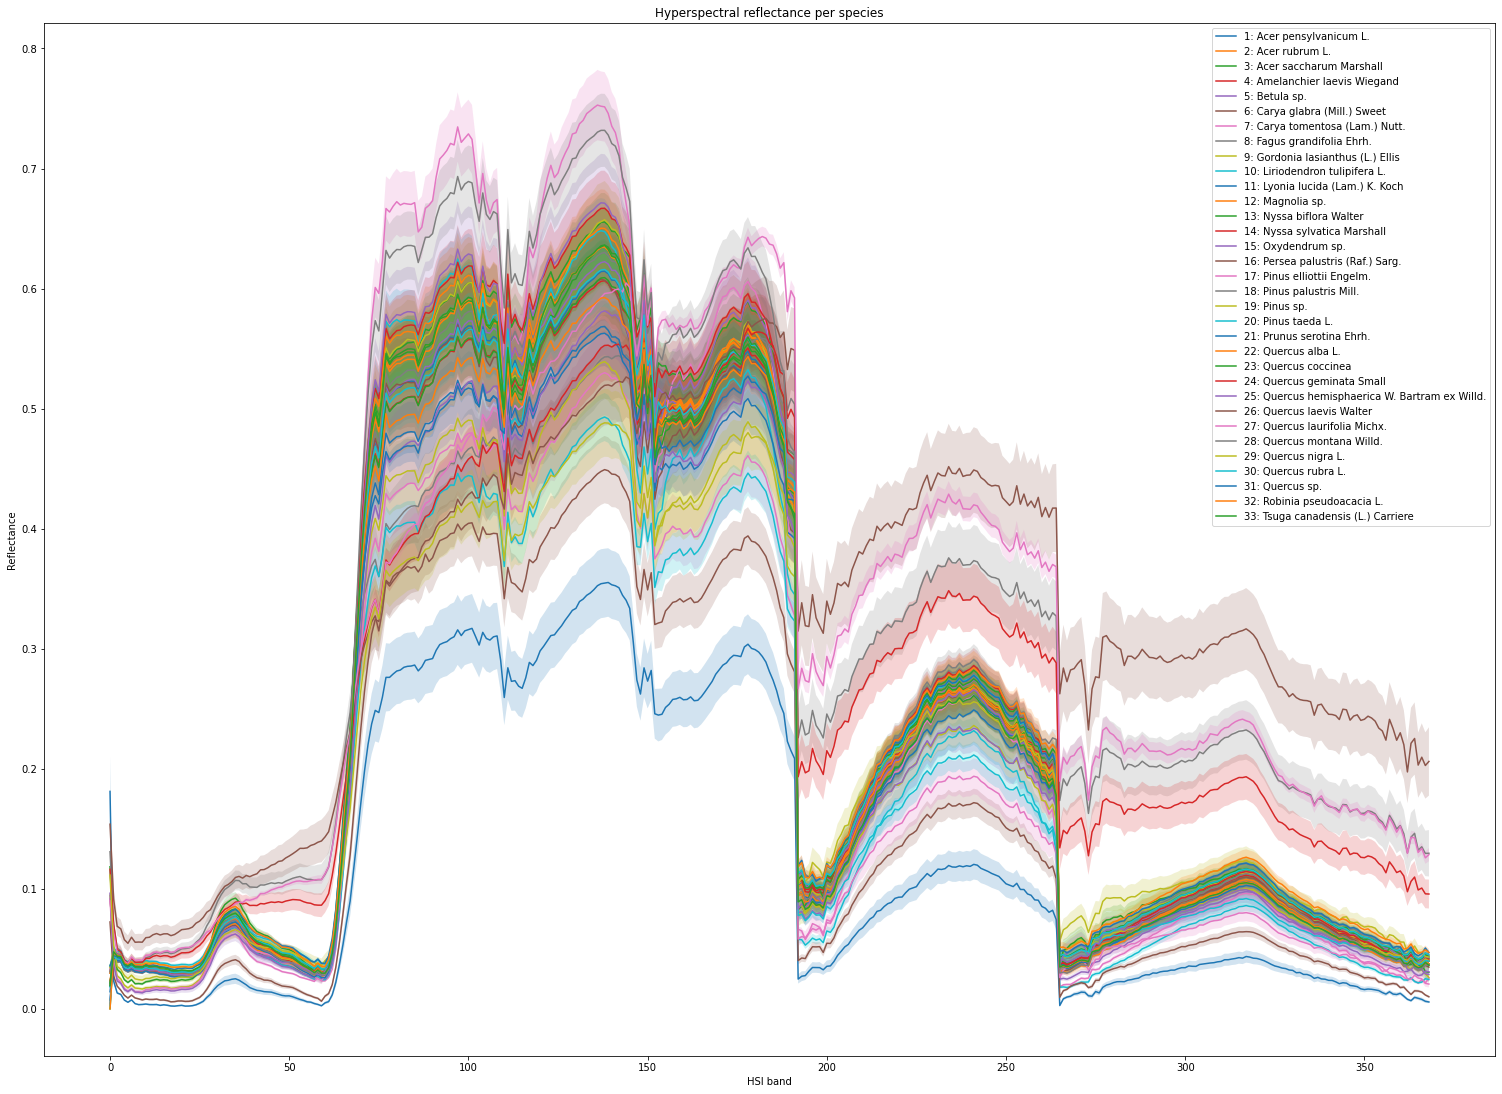

In [10]:
read_tifs.plot_hyperspectral_curve_per_species(data, class_ids, scale_std = 1/5.)

## Plot histogram of each tree species (class)
#### Insights
- There is little outlier data
- Histograms do vary over species


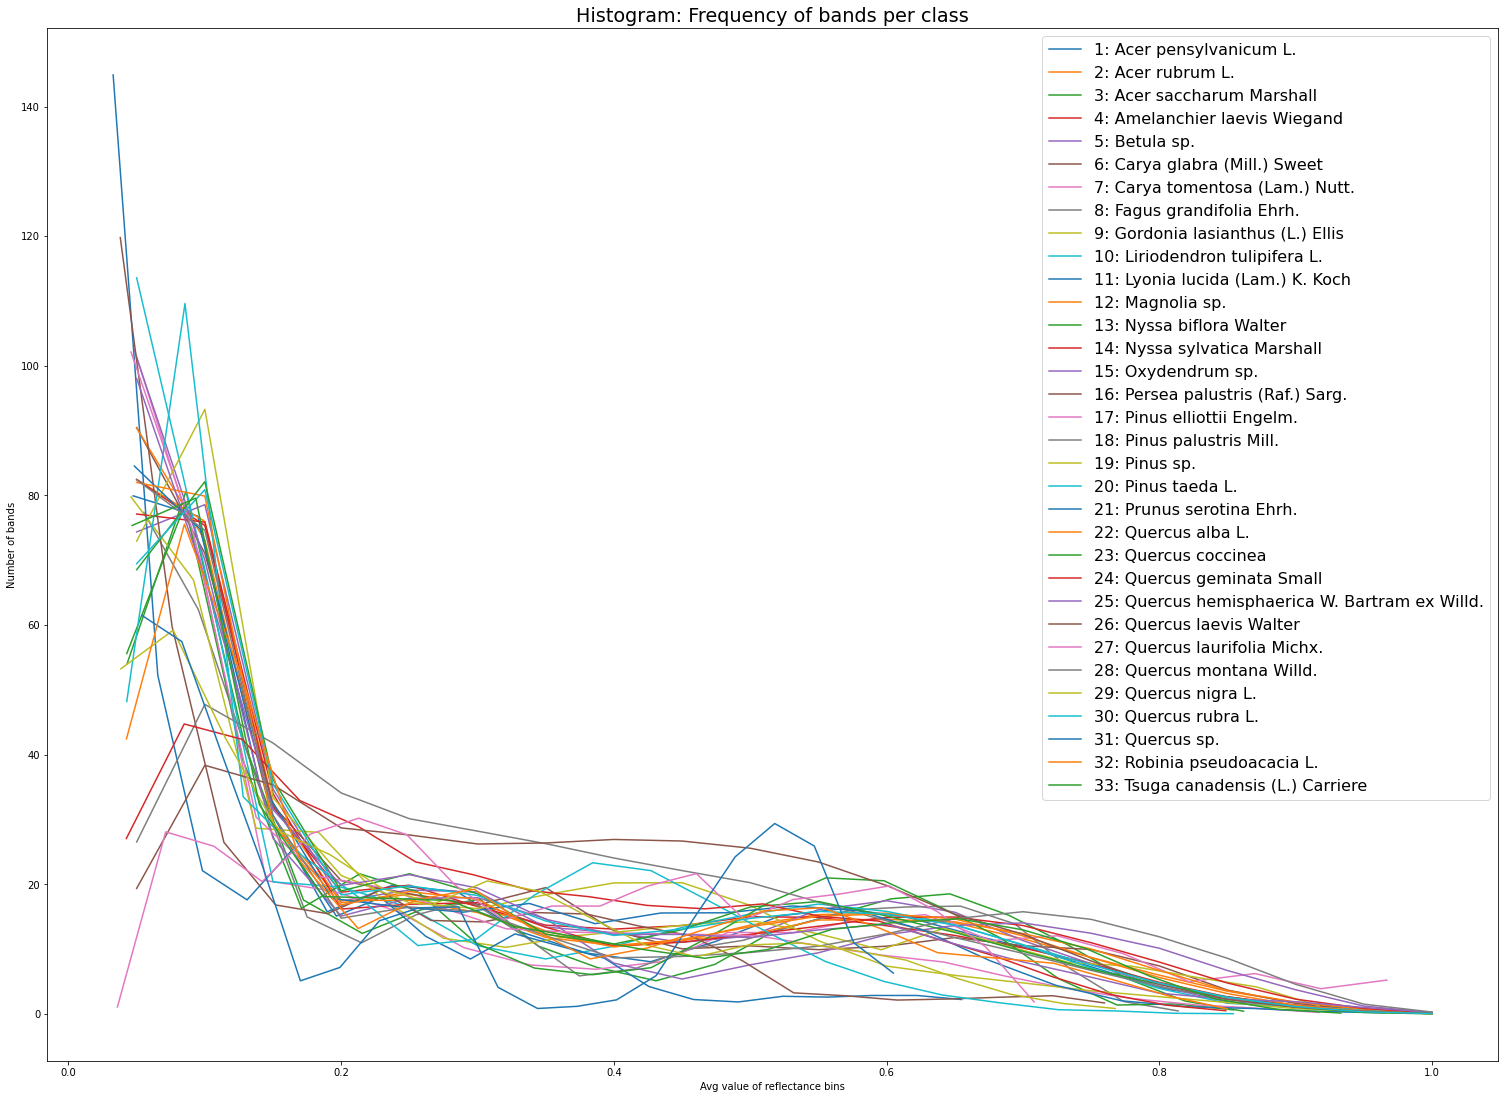

In [11]:
read_tifs.plot_histogram_per_species(data, class_ids, n_bins=20)

### Reduce Number of Classes, to classes with over 400 observations 

In [12]:
data2 = data
df2 = freq.loc[freq['num_pix'] >= 200]
# df2 = df2.drop # TODO: I think this is a bug?

new_class_ids = np.array(df2.class_ids)

print(new_class_ids)

rows, columns = data2.shape
index_cols = []

for c in new_class_ids: 
    trees_in_c = np.argwhere([data2[0,:] == c])
    #new_data = data2[:, trees_in_c[:, 1]]

for i in range(0, columns): 
    if (data2[0, i] in new_class_ids):
        index_cols.append(i)

#print(index_cols)
data_new = data2[:, index_cols]
#print(data_new)

[ 1.  2.  4.  6. 10. 12. 14. 15. 18. 19. 20. 22. 23. 24. 26. 28. 30.]


In [13]:
# df_sci_name = pd.read_csv(repo_path + 'data/train/Field/taxonID_ScientificName.csv')

# fig, axs = plt.subplots(1, 1, figsize = (26, 19))

# for c in new_class_ids: 
#     trees_in_c = np.argwhere([data_new[0,:] == c])
#     print(c)
#     spectra_in_c = data_new[1:, trees_in_c[:, 1]]
#     hist = np.histogram(spectra_in_c, bins = 20)
#     print(hist)

In [14]:
# #print(class_ids)
# #print(data)
# print(i)
# print(columns)

# print(data.shape)
# print(data_new.shape)
# print(np.unique(data_new[0,:]))
# print(new_class)
# print(new_class_ids)


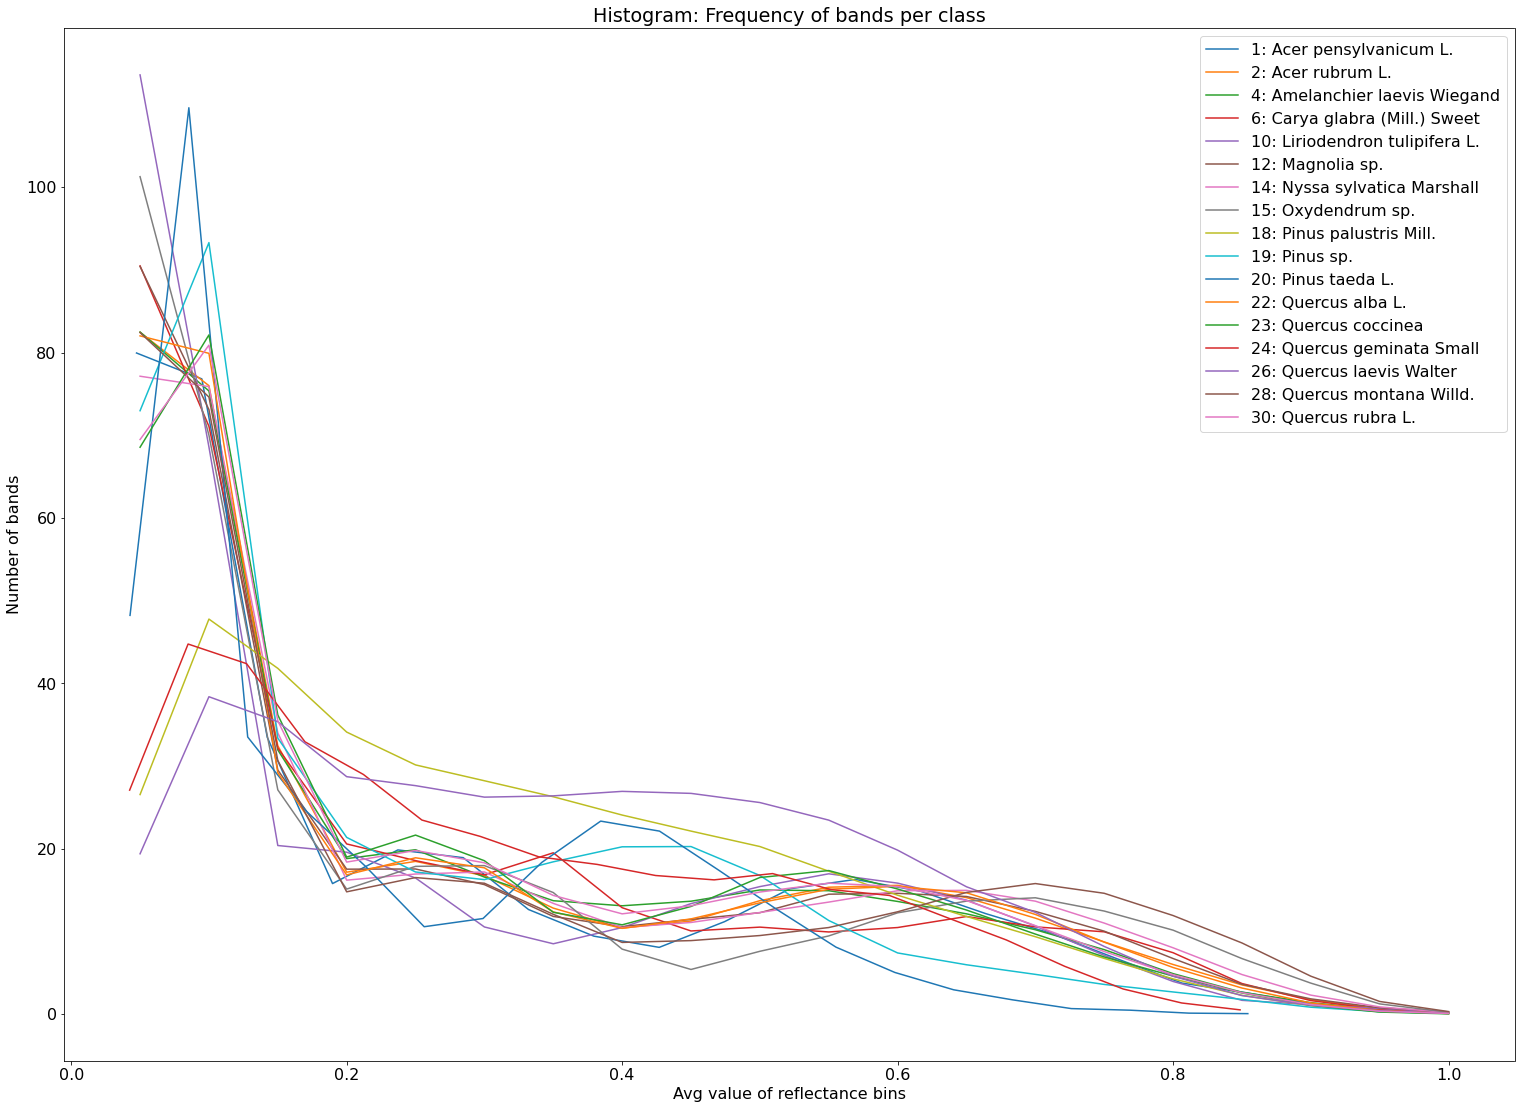

In [15]:
read_tifs.plot_histogram_per_species(data_new, new_class_ids, n_bins=20)

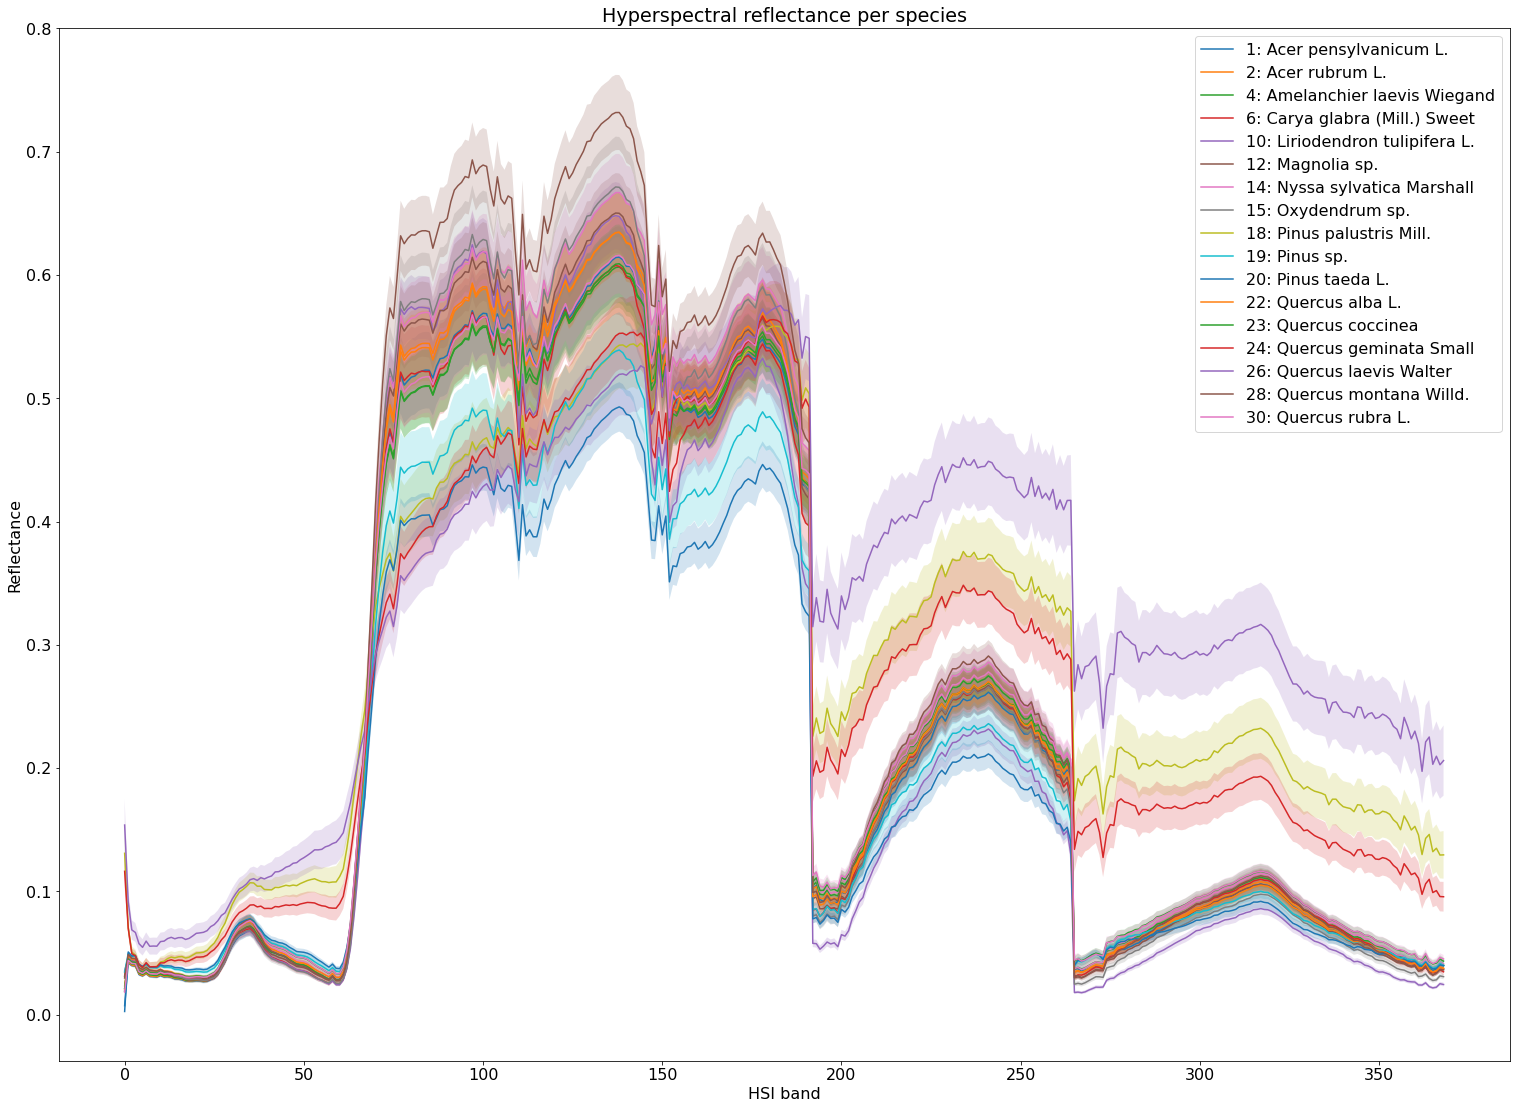

In [16]:
read_tifs.plot_hyperspectral_curve_per_species(data_new, new_class_ids, scale_std = 1/5.)

In [17]:
data3 = data2[:, index_cols]
data3.shape

(370, 34304)

In [19]:
# print(data_test.shape)
print(data.shape)

(370, 35488)
